# **Credits**
Creator: Long Vo <br>
Date: 11/10/2022 <br>
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import warnings

# Load Data

In [2]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)
hidden_weight = np.loadtxt('../assets/hidden_weights.txt')
EPOCHS = 800
#suppress warnings
warnings.filterwarnings('ignore')

In [3]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [4]:
y_train

array([0, 7, 4, ..., 9, 1, 1])

# Neural Network

In [5]:
class NeuralNetwork():
    
    def __init__(self, input_nn: int, output_nn: int, hidden_nn: list, hidden_layers: int, learning_rate=0.01, alpha=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_nn = input_nn
        self.output_nn = output_nn
        self.hidden_nn = hidden_nn
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.high = high
        self.low = low
        # self.b = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_nn[0])])
        self.b1 = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_nn[0])]) 
        self.y_hat = OrderedDict()
        # self.w1 = np.random.randn(self.hidden_nn[0], self.input_nn) * np.sqrt(1 / (self.input_nn + self.hidden_nn[0]))
        self.w1 = hidden_weight
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_nn, self.hidden_nn[0]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[0]))
            self.b2 = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.output_nn)])
        else:
            # add more bias for other layers
            self.w_dict = dict()
            self.b_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                b_temp = 'b' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.randn(self.output_nn, self.hidden_nn[i]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[i]))
                    self.b_dict[b_temp] = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.output_nn)])
                    break
                self.w_dict[temp] = np.random.randn(self.hidden_nn[i + 1], self.hidden_nn[i]) * np.sqrt(1 / (self.hidden_nn[i + 1] + self.hidden_nn[i]))
                self.b_dict[b_temp] = np.array([np.random.uniform(-0.5, 0.5, None) for _ in range(self.hidden_nn[i])])
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x):
        # if -x > np.log(np.finfo(type(x)).max):
        #     return 0.0    
        return 1.0/(1.0 + np.exp(-x))


    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.z1 = np.dot(input_ds, self.w1.T) + self.b1
        self.y_hat1 = self.sigmoid(self.z1)
        if self.hidden_layers < 2:
            self.z2 = np.dot(self.y_hat1, self.w2.T) + self.b2 # net input 
            self.y_hat2 = self.sigmoid(self.z2) # activation function for the output layer.
        else:
            self.z2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b2 # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.z2)
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                temp_b = 'b' + str(i + 2)
                z = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b_dict[temp_b]
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(z)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, input_ds, y, epochs):
        
        m, n = input_ds.shape
          
        if self.hidden_layers < 2:
            self.theta(self.y_hat2)
            self.output_errors = y - self.y_hat2
            
            self.d_output = self.output_errors * self.sigmoid_prime(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            # self.d_hidden = self.sigmoid_prime(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            deltaw2 = self.learning_rate * np.dot(self.y_hat1.T, self.d_output) # Weights change for the second layer (hidden - output)           
            # deltaw1 = self.learning_rate * np.dot(input_ds.T, self.d_hidden) # Weights change for the first layer (input - hidden)

            # delta_b1 = 0
            # delta_b2 = 0
            
            # delta_b1 = 0
            delta_b2 = 1 / m * np.sum(self.output_errors) * self.learning_rate
            
            if epochs > 1: #run after epoch = 1 
                deltaw2 += (self.alpha * self.pre_deltaw2) 
                # deltaw1 += (self.alpha * self.pre_deltaw1)
                delta_b2 -= (self.alpha * self.pre_delta_b2)
                # delta_b1 -= (self.alpha * self.pre_delta_b1)
                self.w2 += deltaw2.T # for (hidden - output)
                # self.w1 += deltaw1.T # for (input - hidden)
                # self.b1 += delta_b1
                self.b2 += delta_b2
            
            self.pre_deltaw2 = deltaw2 # update of weights change
            # self.pre_deltaw1 = deltaw1 
            self.pre_delta_b2 = delta_b2 # update of bias change
            # self.pre_delta_b1 = delta_b1
        
        else:
            
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.theta(self.y_hat_value[1])            
            self.output_errors = y - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.sigmoid_prime(self.y_hat_val[index][1])
                self.d_hidden = self.sigmoid_prime(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                deltaw2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output) # Weights change for the second layer (hidden - output)
                deltaw1 = self.learning_rate * np.dot(np.transpose(input_ds), self.d_hidden) # Weights change for the first layer (input - hidden)

                if(epochs > 1): #run after epoch = 1 
                    deltaw2 += (self.alpha * self.pre_deltaw2) 
                    deltaw1 += (self.alpha * self.pre_deltaw1)
                    delta_b2 += (self.alpha * self.pre_delta_b2)
                    delta_b1 += (self.alpha * self.pre_delta_b1)
                    self.w2 += deltaw2.T # for (hidden - output)
                    self.w1 += deltaw1.T # for (input - output)
                    self.b1 += delta_b1
                    self.b2 += delta_b2
                
                self.pre_deltaw2 = deltaw2 # update of weights change
                self.pre_deltaw1 = deltaw1 
                self.pre_delta_b2 = delta_b2 # update of bias change
                self.pre_delta_b1 = delta_b1
                index -= 1
                self.theta(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def theta(self, y_hat): # set theta for output values. Use during training.
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0
        # for idx in range(len(y_hat)):
        #     if y_hat[idx] >= self.high:
        #         y_hat[idx] = 1.0
        #     elif y_hat[idx] <= self.low:
        #         y_hat[idx] = 0.0

# Train Neural Network

In [6]:
def identify(y): # classify the output, get digit
    results = []
    for data in y:
        max_output = np.amax(data)
        count = 0
        for x in (data): 
            if x == max_output:
                results.append(count)
            count += 1
    return np.asarray(results)

def one_hot_encode(y): 
    one_hot_y = np.zeros((y.size, 10))
    one_hot_y[np.arange(y.size), y] = 1 
    out_hot_labels = one_hot_y.T
    return one_hot_y


def accuracy(y, yhat): 
    ERRORS = 0
    yhat_one = one_hot_encode(np.int_(identify(yhat)))
    for i in range(len(y)):
        for j in range(len(y[0])):
            if y[i][j] != yhat_one[i][j]:
                ERRORS += 1
                break
    return (ERRORS / len(y)) * 100

In [7]:
nn = NeuralNetwork(784, 10, [180], 1)
nn.forward_prop(x_train)
y_onehot = one_hot_encode(y_train)
y_test_onehot = one_hot_encode(y_test)
w1, w2 = nn.get_weight()
train_error_frac, test_error_frac = list(), list()

In [8]:
w1 # for testing to see in the weight did get train

array([[ 0.00615303,  0.03509156, -0.01830187, ..., -0.02930204,
        -0.02751705,  0.01583924],
       [ 0.00276875, -0.03903014, -0.02849899, ...,  0.01471919,
         0.00547539, -0.04100142],
       [ 0.04148321,  0.0194128 , -0.00305757, ..., -0.05565823,
         0.0586446 ,  0.06678386],
       ...,
       [-0.00296191,  0.03365274, -0.03516757, ...,  0.02560871,
         0.00375103,  0.02143028],
       [ 0.07132253,  0.06153575, -0.08962715, ...,  0.04336144,
        -0.00796287, -0.06970343],
       [ 0.03858584,  0.05227889, -0.05092477, ..., -0.05409208,
        -0.07112448,  0.0215019 ]])

In [9]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_train = accuracy(y_onehot, nn.get_output())
        train_error_frac.append(temp_train)
        print(f'Error fraction: {temp_train}')
    nn.backward_prop(x_train, y_onehot, i)
    if i % 10 == 0:
        nn.forward_prop(x_test)
        temp_test = accuracy(y_test_onehot, nn.get_output())
        test_error_frac.append(temp_test)

Iteration 0:
Error fraction: 92.925
Iteration 10:
Error fraction: 19.15
Iteration 20:
Error fraction: 13.625000000000002
Iteration 30:
Error fraction: 11.600000000000001
Iteration 40:
Error fraction: 10.549999999999999
Iteration 50:
Error fraction: 9.725
Iteration 60:
Error fraction: 8.9
Iteration 70:
Error fraction: 8.425
Iteration 80:
Error fraction: 8.0
Iteration 90:
Error fraction: 7.85
Iteration 100:
Error fraction: 7.8
Iteration 110:
Error fraction: 7.6
Iteration 120:
Error fraction: 7.375
Iteration 130:
Error fraction: 7.225
Iteration 140:
Error fraction: 7.074999999999999
Iteration 150:
Error fraction: 7.049999999999999
Iteration 160:
Error fraction: 7.049999999999999
Iteration 170:
Error fraction: 6.950000000000001
Iteration 180:
Error fraction: 6.875000000000001
Iteration 190:
Error fraction: 6.9
Iteration 200:
Error fraction: 6.950000000000001
Iteration 210:
Error fraction: 7.025
Iteration 220:
Error fraction: 7.025
Iteration 230:
Error fraction: 6.875000000000001
Iteration 

### Accuracy on test set

In [10]:
nn.forward_prop(x_test)
print(accuracy(y_test_onehot, nn.get_output())) # check accuracy on test set

13.3


# Confusion Matrices

In [11]:
def index_output(y): 
    max_out = np.amax(y)
    counter = 0
    for x in y:
        if x == max_out:
            return counter
        counter += 1


def confusion_matrix(y, yhat):
    confuse = np.zeros((10, 10))
    for i, x in enumerate(y):
        y_output = int(index_output(x))
        yhat_output = int(index_output(yhat[i]))
        confuse[y_output][yhat_output] += 1
    return confuse

### Confusion matrix for training set

In [12]:
nn.forward_prop(x_train)
train_CM = confusion_matrix(y_onehot, one_hot_encode(np.int_(identify(nn.get_output()))))
train_frame = pd.DataFrame(train_CM)
train_frame.style.background_gradient('Greys').set_caption('TRAIN CONFUSION MATRIX').set_properties(**{'text-align': 'center', 
                        'padding': '12px', 
                        'width': '50px'}).set_table_styles([{'selector': 'th.col_heading', 
                         'props': 'text-align: center'},
                        {'selector': 'caption', 
                         'props': [('text-align', 'center'),
                                   ('font-size', '11pt'),
                                   ('font-weight', 'bold')]}])
# train_frame.dfi.export('../assets/train_confusematrix.png')

,0,1,2,3,4,5,6,7,8,9
0,397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
1,0.000000,399.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.000000,0.000000,381.000000,0.000000,1.000000,0.000000,3.000000,7.000000,4.000000,1.000000
3,0.000000,1.000000,8.000000,368.000000,0.000000,7.000000,0.000000,8.000000,6.000000,2.000000
4,0.000000,0.000000,2.000000,2.000000,368.000000,0.000000,8.000000,1.000000,3.000000,16.000000
5,0.000000,0.000000,0.000000,9.000000,2.000000,370.000000,6.000000,0.000000,9.000000,4.000000
6,1.000000,1.000000,2.000000,0.000000,3.000000,2.000000,390.000000,1.000000,0.000000,0.000000
7,0.000000,1.000000,4.000000,3.000000,3.000000,0.000000,0.000000,374.000000,4.000000,11.000000
8,3.000000,1.000000,5.000000,13.000000,2.000000,12.000000,6.000000,2.000000,348.000000,8.000000
9,2.000000,1.000000,1.000000,4.000000,14.000000,6.000000,0.000000,20.000000,5.000000,347.000000


### Confusion matrix for testing set

In [13]:
nn.forward_prop(x_test)
test_CM = confusion_matrix(y_test_onehot, one_hot_encode(np.int_(identify(nn.get_output()))))
test_frame = pd.DataFrame(test_CM)
test_frame.style.background_gradient('Greys').set_caption('TEST CONFUSION MATRIX').set_properties(**{'text-align': 'center', 
                        'padding': '12px', 
                        'width': '50px'}).set_table_styles([{'selector': 'th.col_heading', 
                         'props': 'text-align: center'},
                        {'selector': 'caption', 
                         'props': [('text-align', 'center'),
                                   ('font-size', '11pt'),
                                   ('font-weight', 'bold')]}])
# print(test_frame)
# test_frame.dfi.export('../assets/test_confusematrix.png')

,0,1,2,3,4,5,6,7,8,9
0,92.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
1,0.000000,97.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,1.000000,1.000000,87.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,1.000000
3,0.000000,1.000000,2.000000,84.000000,0.000000,4.000000,1.000000,2.000000,6.000000,0.000000
4,1.000000,0.000000,3.000000,0.000000,82.000000,0.000000,4.000000,2.000000,1.000000,7.000000
5,1.000000,0.000000,0.000000,4.000000,2.000000,88.000000,3.000000,0.000000,2.000000,0.000000
6,0.000000,0.000000,4.000000,0.000000,0.000000,2.000000,92.000000,0.000000,2.000000,0.000000
7,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,88.000000,2.000000,5.000000
8,2.000000,1.000000,4.000000,2.000000,2.000000,3.000000,2.000000,1.000000,79.000000,4.000000
9,0.000000,1.000000,0.000000,0.000000,9.000000,2.000000,1.000000,9.000000,0.000000,78.000000


# Bar plot

In [14]:
def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def digit_extract(data):
    digits = dict()
    for i in range(10):
        digits[i] = get_index_digit(i, data)
    return digits

In [15]:
train_digits, test_digits = digit_extract(y_train), digit_extract(y_test)

In [16]:
def get_accuracy_digit(y, yhat, digits):
    ERRORS = 0
    yhat_one = one_hot_encode(np.int_(identify(yhat)))
    for digit in digits:
        for i in range(len(yhat[0])):
            # print(yhat[digit][i])
            if y[digit][i] != yhat_one[digit][i]:
                ERRORS += 1
                break
    return (ERRORS / (len(digits)))
    
def get_dataset_error(x, x_out, digits):
    errors = dict()
    for i in digits:
        errors[i] = get_accuracy_digit(x, x_out, digits[i])
    return errors
    

In [17]:
nn.forward_prop(x_train)
train_output = nn.get_output()
nn.forward_prop(x_test)
test_output = nn.get_output()

In [18]:
ERROR_TRAIN, ERROR_TEST = get_dataset_error(y_onehot, train_output, train_digits), get_dataset_error(y_test_onehot, test_output, test_digits)

In [19]:
ERROR_TEST

{0: 0.08,
 1: 0.03,
 2: 0.13,
 3: 0.16,
 4: 0.18,
 5: 0.12,
 6: 0.08,
 7: 0.12,
 8: 0.21,
 9: 0.22}

In [20]:
total_train_error = sum(ERROR_TRAIN.values()) / len(ERROR_TRAIN)
total_test_error = sum(ERROR_TEST.values()) / len(ERROR_TEST)

Text(0, 0.5, 'Total Error')

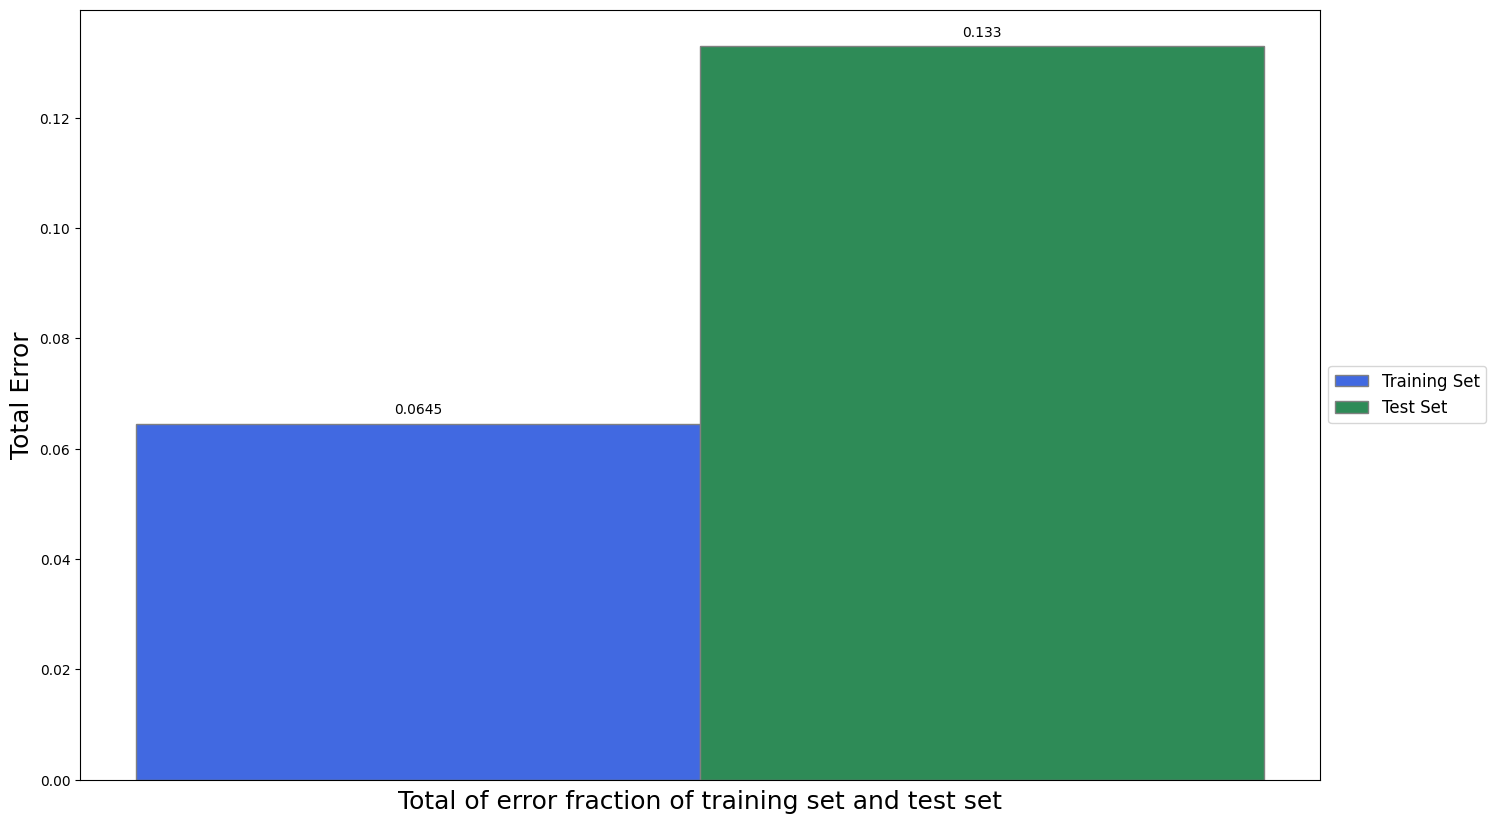

In [21]:
train_set = tuple([total_train_error])
test_set = tuple([total_test_error])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(1-0.5, train_set, width=0.5, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(1, test_set, width=0.5, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')

ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
ax.set_xticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Total of error fraction of training set and test set', fontsize=18)
plt.ylabel('Total Error', fontsize=18)

Text(0.5, 1.0, 'Average error fraction for Training and Testing Set per number')

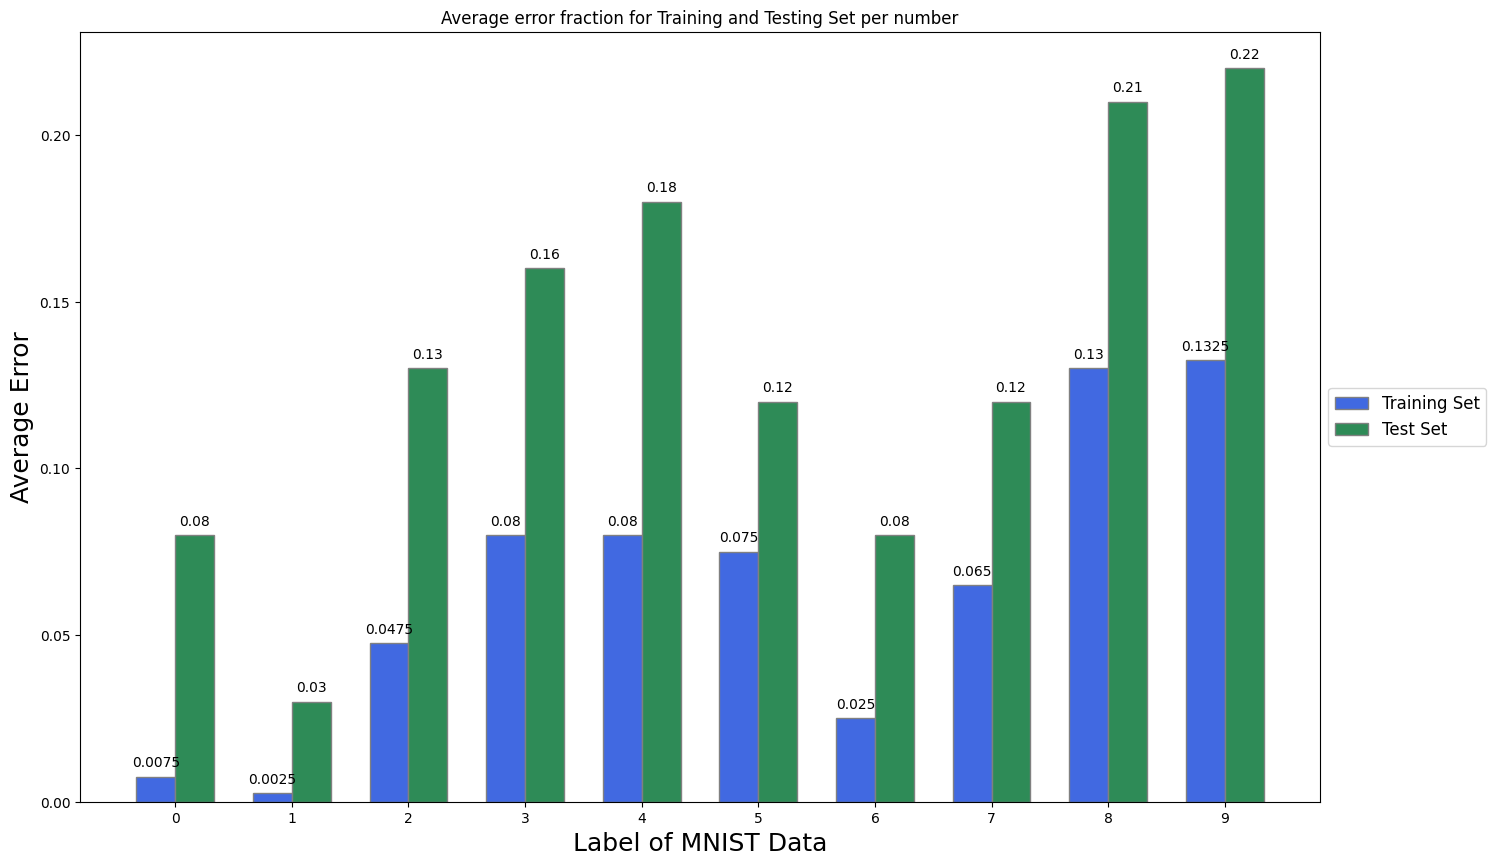

In [22]:
train_set = tuple(ERROR_TRAIN.values())
test_set = tuple(ERROR_TEST.values())
index = list(ERROR_TEST.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in index]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Average error fraction for Training and Testing Set per number')

# Time series plot

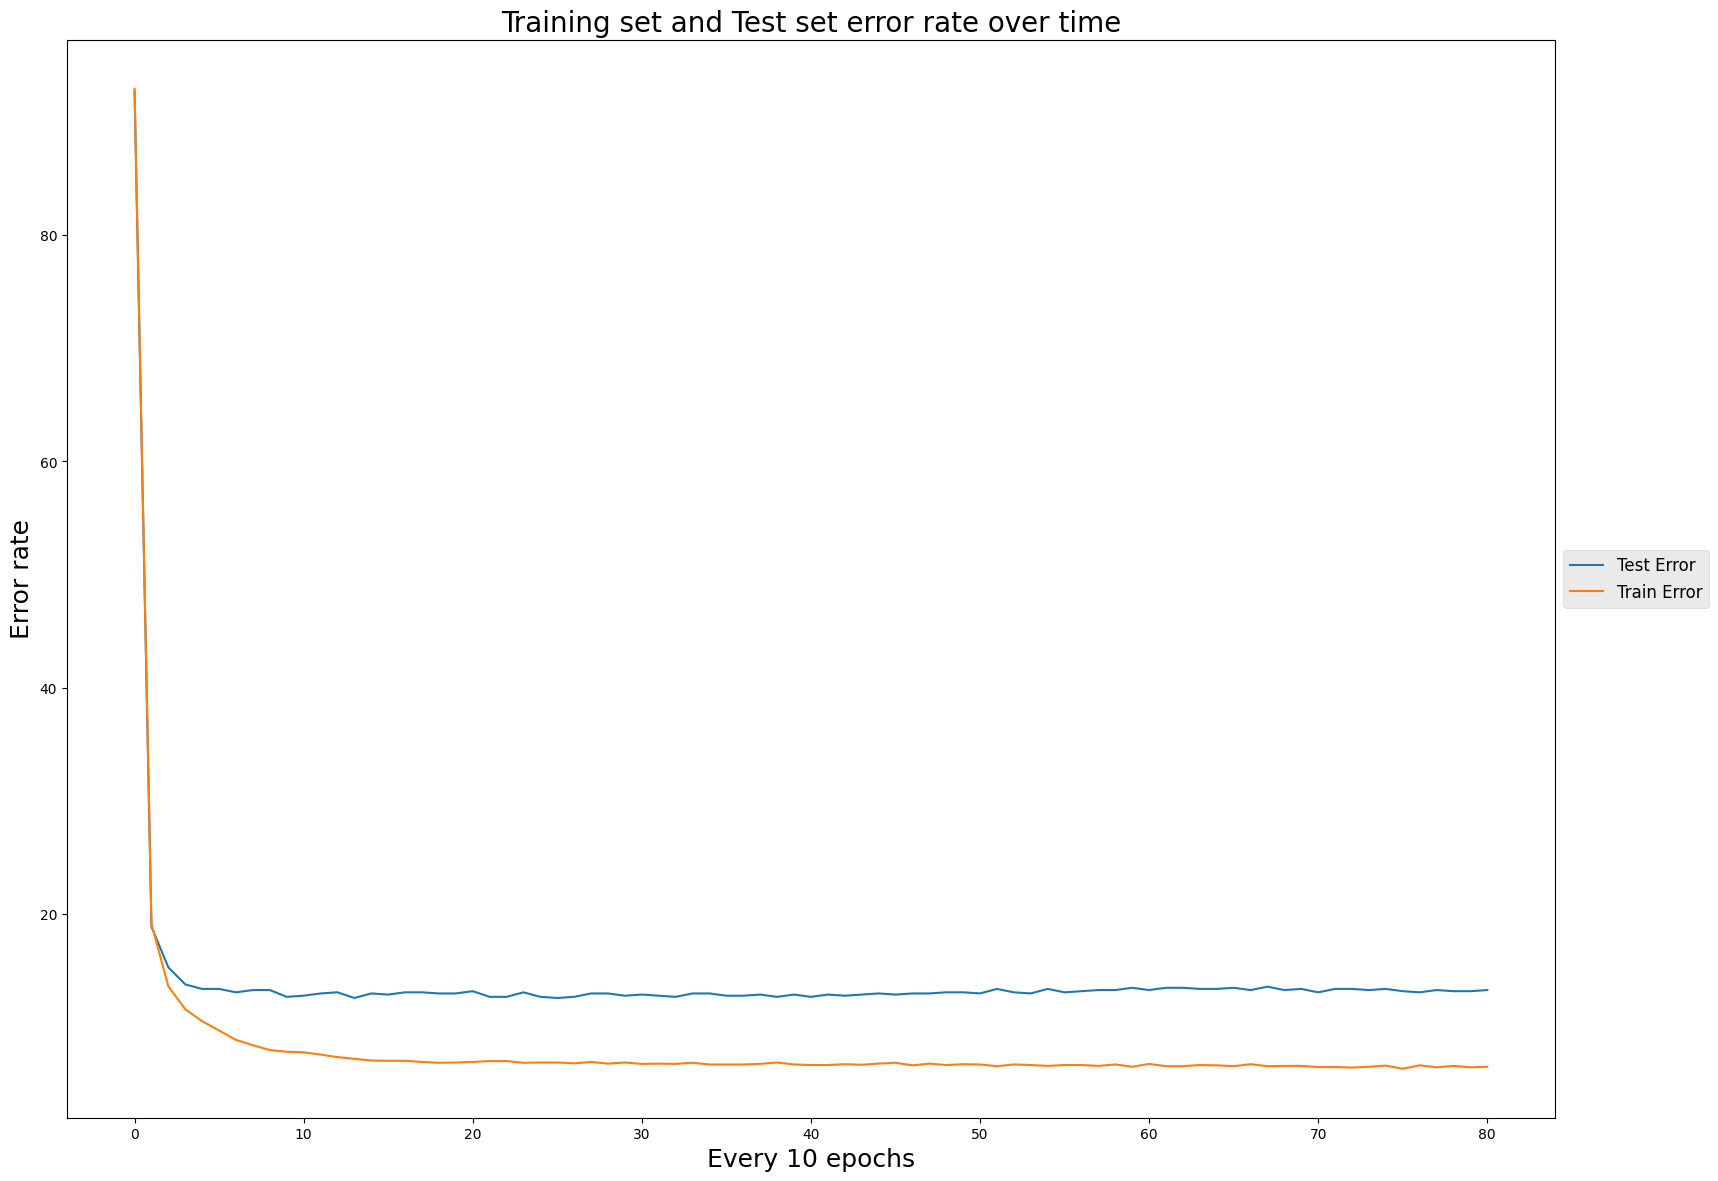

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 14))
plt.style.use('ggplot')
fraction = [test_error_frac, train_error_frac]
graph_label = ['Test Error', 'Train Error']
for i, x in enumerate(fraction):
    plt.plot(x, label=graph_label[i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.title('Training set and Test set error rate over time', fontsize=20)
plt.xlabel('Every 10 epochs', fontsize=18)
plt.ylabel('Error rate', fontsize=18)
fig.savefig('../assets/error_fraction.png')